# COCO Dataset, Object Classification Comparing XCeption V1 and VGG19
## Utilizing subset of 10,000 images from the COCO Dataset
### By: Luis Cervantes & Sean Krinik


#### Sources: 
**Coco Dataset:** [Common Objects in Context](http://cocodataset.org/#home) - Data source along with API. <br>
**Keras.io:** [Keras.io](https://keras.io/) - All model implementation and documentation on models.

In [44]:
import numpy as np
import random
import pandas as pd
import sys, os, os.path, glob, time
import cv2
from scipy import stats
from scipy import misc
import concurrent.futures
import matplotlib.pyplot as plt
%matplotlib inline
from pycocotools.coco import COCO

from keras.models import Sequential, load_model, model_from_json
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
import keras.utils 
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD, Adadelta
import h5py

In [2]:
# Plot Loss Function:
def plot_loss_accuracy(history, modelnum):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history.history["loss"],'r-x', label="Train Loss")
    ax.plot(history.history["val_loss"],'b-x', label="Validation Loss")
    ax.legend()
    ax.set_title(modelnum + ' Cross Entropy Loss')
    ax.grid(True)


    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history.history["acc"],'r-x', label="Train Accuracy")
    ax.plot(history.history["val_acc"],'b-x', label="Validation Accuracy")
    ax.legend()
    ax.set_title(modelnum + ' Accuracy')
    ax.grid(True)

In [3]:
dataDir='.'
valAnnFile='{}/annotations/instances_{}.json'.format(dataDir,'val2017')
trainAnnFile='{}/annotations/instances_{}.json'.format(dataDir,'train2017')
train_path='{}/images/{}/'.format(dataDir,'train2017')
val_path='{}/images/{}/'.format(dataDir,'val2017')
test_path='{}/images/{}/'.format(dataDir,'test2017')

filename_train = 'train_info.csv'
filename_val = 'val_info.csv'

models_dir_x = './modelsx/'
models_dir_v = './modelsv/'

## TEST: check number of files in directory: 
# print(len([name for name in os.listdir(train_path) if os.path.isfile(train_path + name)]))

In [4]:
coco_train=COCO(trainAnnFile)
coco_val=COCO(valAnnFile)

loading annotations into memory...
Done (t=24.54s)
creating index...
index created!
loading annotations into memory...
Done (t=0.69s)
creating index...
index created!


In [5]:
# Annotations:
anns_train = coco_train.loadAnns(coco_train.getAnnIds())
anns_val = coco_val.loadAnns(coco_val.getAnnIds())

# Categories:
cats_train = coco_train.loadCats(coco_train.getCatIds())
cats_val = coco_val.loadCats(coco_val.getCatIds())

# Images:
imgs_train = coco_train.loadImgs(coco_train.getImgIds())
imgs_val = coco_val.loadImgs(coco_val.getImgIds())

Taking a look at the sizes of images:

In [6]:
sizes = [[img['height'], img['width']] for img in imgs_train]
print(max(sizes[:]))
print(min(sizes[:]))
print(np.mean(sizes[0]),np.mean(sizes[1]))

[640, 640]
[51, 72]
(533.5, 560.0)


And the possible categories list:

In [7]:
nms=[cat['name'] for cat in cats_train]
print('COCO categories: \n{}\n'.format(', '.join(nms)))

COCO categories: 
person, bicycle, car, motorcycle, airplane, bus, train, truck, boat, traffic light, fire hydrant, stop sign, parking meter, bench, bird, cat, dog, horse, sheep, cow, elephant, bear, zebra, giraffe, backpack, umbrella, handbag, tie, suitcase, frisbee, skis, snowboard, sports ball, kite, baseball bat, baseball glove, skateboard, surfboard, tennis racket, bottle, wine glass, cup, fork, knife, spoon, bowl, banana, apple, sandwich, orange, broccoli, carrot, hot dog, pizza, donut, cake, chair, couch, potted plant, bed, dining table, toilet, tv, laptop, mouse, remote, keyboard, cell phone, microwave, oven, toaster, sink, refrigerator, book, clock, vase, scissors, teddy bear, hair drier, toothbrush



Here we get the ids for all images, from the image objects, so there are no duplicates - only unique images

In [8]:
# Get list of image id's for train & validation sets
# Use to match with image id's and get the various categories.
img_ids_train = [img['id'] for img in imgs_train]
img_ids_val = [img['id'] for img in imgs_val]

The following function is definitely not optimized or vectorized but it was the best we could come up with in a breif period to be able to concatenate categories with the correct images, and obtain the most common object instance to make this what we classify the image as. The docstring explains the functionality. 

In [9]:
# creates a sorted data frame to hold categories:
def get_labels_by_imgid(annotations, image_set):
    """
    get_labels_by_imgid gets the categories associated with each
    image, and then labels that image with the most common category
    id (or most common instance of an object in the image).
    
    INPUTS: annotation set, image set (from getAnns/getImgs)
    
    RETURNS: Pandas DF with categories & id's
    """
    print('loading image annotations...')
    # for local machine, only use 5000 images in train/val/test
    if len(image_set) > 5000:
        image_set = image_set[0:10000]
    # get the image id's from the specified image set (train/test/val)
    image_ids = [img['id'] for img in image_set]
    # initialize dataframe
    df = pd.DataFrame(columns=['id','categories'])
    # enumerate the image id's list to obtain the categories associated with id's
    for (i,val) in enumerate(image_ids):
        ids = [annotations[imgid]['category_id'] for imgid, x in enumerate(annotations) if x['image_id'] == val]
        df.loc[i] = val, stats.mode(ids)[0][0] if len(ids)>0 else 0
    print('Done.')
    return df

In [10]:
exists = os.path.isfile(filename_train)
if exists:
    train_data = pd.read_csv(filename_train,index_col=0)
else:
    train_data = get_labels_by_imgid(anns_train, imgs_train)
    train_data.to_csv(filename_train)

In [11]:
exists = os.path.isfile(filename_val)
if exists:
    val_data = pd.read_csv(filename_val,index_col=0)
else:
    val_data = get_labels_by_imgid(anns_val, imgs_val)
    val_data.to_csv(filename_val)

Check the data frames:

In [12]:
print(train_data.head())
print(val_data.head())

       id  categories
0  262145           1
1  262146           1
2  524291          18
3  262148           1
4  524297           1
       id  categories
0  532481           3
1   66231           1
2  458755           1
3  245764          17
4  385029          44


These functions change the id's to filenames by adding the necessary 0's and extension to create the filename string. This just makes it easier to work with the above dataframe.

In [13]:
def change_to_filename(x):
    return (12-len(str(x)))*'0'  + str(x) + '.jpg'

def get_filenames_array(arr):
    return np.array([change_to_filename(x) for x in arr])

In [14]:
train_filenames = get_filenames_array(train_data['id'])
val_filenames = get_filenames_array(val_data['id'])

In [15]:
img_height = img_width = 256

The following two functions are redundant, but essential. There is only one parameter since I tried to use multicore processing to speed up the image preprocessing. Using the concurrent futures module to create a ProcessPoolExecutor instance, I was able to use the map function to call the `make_image_data_*` function on the respective set. The reason for the redundancy is the fact that using multiple arguements is difficult, thus I made functions for each set instead of requiring a path argument.

In [16]:
def make_image_data_train(filename):
    img = cv2.imread(train_path + filename)
    img = cv2.resize(img,(img_width, img_height), interpolation = cv2.INTER_CUBIC)        
    if len(img.shape) == 3:
        img = np.array(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        img = np.stack((img,)*3, axis=-1)
    return img

In [17]:
def make_image_data_val(filename):
    img = cv2.imread(val_path + filename)
    img = cv2.resize(img,(img_width, img_height), interpolation = cv2.INTER_CUBIC)        
    if len(img.shape) == 3:
        img = np.array(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        img = np.stack((img,)*3, axis=-1)
    return img

In [18]:
x_train = []
with concurrent.futures.ProcessPoolExecutor() as executor:
    for imagedata in executor.map(make_image_data_train, train_filenames):
        x_train.append(imagedata)
    x_train = np.array(x_train)

In [19]:
x_val = []
with concurrent.futures.ProcessPoolExecutor() as executor:
    for imagedata in executor.map(make_image_data_val, val_filenames):
        x_val.append(imagedata)
    x_val = np.array(x_val)

In [20]:
print(x_train.shape)
print(x_val.shape)

(10000, 256, 256, 3)
(5000, 256, 256, 3)


Note, we are using 10000 images as a training set, but the validation split will be `80%`|`20%` (8000, 2000). The 'test' set is actually the validation set as provided by COCO, which includes 5000 labeled images. This set will give us a control test to evaluate for each model.

In [21]:
datagen = ImageDataGenerator(rescale=1./255.,
                             validation_split=0.2,
                             rotation_range=15,
                             width_shift_range=0.05,
                             shear_range=0.25,
                             height_shift_range=0.05,
                             zoom_range=0.05)

There are 91 classes because some of the images actually had no categories associated with them, so we labeled these as category 0. 

In [22]:
number_of_classes = 91;
y_train = keras.utils.to_categorical(train_data['categories'], number_of_classes)
y_val = keras.utils.to_categorical(val_data['categories'], number_of_classes)

In [23]:
batch_size = 16 
train_gen = datagen.flow(x_train,
                            y_train,
                            subset= "training",
                            shuffle = True,
                            batch_size=batch_size)

val_gen = datagen.flow(x_train,
                            y_train,
                            subset = "validation",
                            shuffle = False,
                            batch_size=batch_size)

### XCeption V1

In [54]:
from keras.applications import Xception
from keras import Model

In [55]:
def create_model(inputsize):
    optimizer_x = SGD(lr=.0005, momentum=0.9, decay=2.5e-5, nesterov=True)
    base_model = Xception(input_shape=(inputsize, inputsize, 3), weights='imagenet', include_top=False)
    # replace the fully connected layer to fit our application:
    output = base_model.output
    output = GlobalAveragePooling2D()(output)
    output = Dense(number_of_classes, activation='softmax')(output)
    model = Model(base_model.input, output)
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer_x,
                  metrics=['accuracy', 'top_k_categorical_accuracy'])
    return model

# top_model_path = models_dir_x+'topmodel_{epoch:02d}_{val_loss:.2f}.hdf5'
callbacks_list = [
#     ModelCheckpoint(top_model_path, monitor='val_acc', verbose=1, save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=4, verbose=1)
]
model = create_model(img_width)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

We adjusted the learning rate and decay to fit our application. We have much less data to work with so choosing a faster learning rate for stochastic gradient descent will help us reach peak loss faster. The paper with specs for XCeption are here:

[Xception: Deep Learning with Depthwise Separable Convolutions](https://arxiv.org/pdf/1610.02357.pdf)

In [56]:
exists_x = len(os.listdir(models_dir_x)) != 0

In [57]:
# check if model exists
if exists_x: 
    print('Loading previous model...')
    model = load_model(glob.glob(models_dir_x + '*Xception.hdf5')[0])
    print('Xception Loaded.')
else:
    # train the model since no previous model exists.
    epochs = 60
    steps_train_data = train_gen.n//train_gen.batch_size
    steps_val_data = val_gen.n//val_gen.batch_size
    start = time.time()
    model_trained = model.fit_generator(train_gen,
                                       steps_per_epoch=steps_train_data,
                                       epochs=epochs,
                                       validation_data = val_gen,
                                       validation_steps = steps_val_data,
                                       callbacks=callbacks_list)
    print('Total time to train Xception V1: {}'.format(time.time()-start))

Epoch 1/60
500/500 [==============================] - 311s 622ms/step - loss: 3.0327 - acc: 0.3984 - top_k_categorical_accuracy: 0.5566 - val_loss: 2.6821 - val_acc: 0.4325 - val_top_k_categorical_accuracy: 0.6435
Epoch 2/60
500/500 [==============================] - 306s 612ms/step - loss: 2.4731 - acc: 0.4505 - top_k_categorical_accuracy: 0.6841 - val_loss: 2.2590 - val_acc: 0.5035 - val_top_k_categorical_accuracy: 0.7405
Epoch 3/60
500/500 [==============================] - 305s 611ms/step - loss: 2.1118 - acc: 0.5211 - top_k_categorical_accuracy: 0.7634 - val_loss: 1.9908 - val_acc: 0.5505 - val_top_k_categorical_accuracy: 0.7870
Epoch 4/60
500/500 [==============================] - 307s 614ms/step - loss: 1.8493 - acc: 0.5747 - top_k_categorical_accuracy: 0.8037 - val_loss: 1.8081 - val_acc: 0.5815 - val_top_k_categorical_accuracy: 0.8140
Epoch 5/60
500/500 [==============================] - 306s 611ms/step - loss: 1.6791 - acc: 0.6025 - top_k_categorical_accuracy: 0.8313 - val_lo

In [58]:
model.save(models_dir_x+'topmodel_Xception.hdf5')

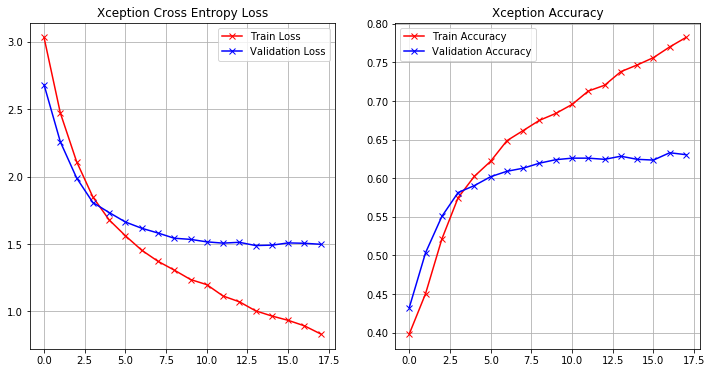

In [60]:
plot_loss_accuracy(model_trained, 'Xception')

#### Evaluation:

In [61]:
score = model.evaluate(x_val, y_val, verbose=1)
print('XCeption V1 Test Loss:', score[0])
print('XCeption V1 Accuracy:', score[1])
print('XCeption V1 Top-5 accuracy:', score[2])

5000/5000 [==============================] - 39s 8ms/step
('XCeption V1 Test Loss:', 12.054959742736816)
('XCeption V1 Accuracy:', 0.2416)
('XCeption V1 Top-5 accuracy:', 0.8204)


### VGG19

VGG 19 utilizes 19 weight layers, and employs small filter, short stride functionality throughout the convolutional layers. The paper on VGG19 can be seen here:

[Very Deep Convolutional Networks For Large-Scale Image Recognition](https://arxiv.org/pdf/1409.1556.pdf)

In [47]:
from keras.applications import VGG19

In [53]:
def create_vgg(num_classes, imgdim):
    base_model = VGG19(input_shape=(imgdim, imgdim, 3), 
                       include_top=False, 
                       weights='imagenet')
    # replace the fully connected layer to fit our application:
    output = base_model.output
    output = GlobalAveragePooling2D()(output)
    output = Dense(num_classes, activation='softmax')(output)
    m_vgg = Model(base_model.input, output)
    m_vgg.compile(loss='categorical_crossentropy',
          optimizer=SGD(lr=0.0001, momentum=0.9, decay=0.0, nesterov=True),
          metrics=['accuracy', 'top_k_categorical_accuracy'])
    return m_vgg

In [54]:
def train_vgg(train_gen, val_gen, n_epochs, n_classes, imgdim, callbacks_bool):
    if callbacks_bool:
        callbacks_list = [
            #ModelCheckpoint(top_model_path, monitor='val_acc', verbose=1, save_best_only=True),
            EarlyStopping(monitor='val_loss', patience=3, verbose=1)
        ]
    else:
        callbacks_list = []
        
    # create model:    
    m_vgg = create_vgg(n_classes, imgdim)
    
    # Begin training:
    steps_train_data = train_gen.n//train_gen.batch_size
    steps_val_data = val_gen.n//val_gen.batch_size
    trained_vgg = m_vgg.fit_generator(train_gen,
                                       steps_per_epoch=steps_train_data,
                                       epochs=n_epochs,
                                       validation_data = val_gen,
                                       validation_steps = steps_val_data,
                                       callbacks=callbacks_list)
    return trained_vgg, m_vgg 

In [55]:
# Same implementation as seen in XCeption case.
exists_vgg = len(os.listdir(models_dir_v)) != 0
if exists: 
    model_files = []
    for file in os.listdir(models_dir_v):
        if file.endswith("VGG19.hdf5"):
            model_files.append(file)
    latest_file = max(model_files, key=os.path.getctime)
    model_vgg = load_model(latest_file)

else:
    trained_vgg, model_vgg = train_vgg(train_gen, val_gen, 60, number_of_classes, img_width, True)

Epoch 1/60
500/500 [==============================] - 235s 470ms/step - loss: 3.1005 - acc: 0.4091 - top_k_categorical_accuracy: 0.5380 - val_loss: 2.7992 - val_acc: 0.4135 - val_top_k_categorical_accuracy: 0.5950
Epoch 2/60
500/500 [==============================] - 234s 468ms/step - loss: 2.6500 - acc: 0.4200 - top_k_categorical_accuracy: 0.6348 - val_loss: 2.5104 - val_acc: 0.4240 - val_top_k_categorical_accuracy: 0.6765
Epoch 3/60
500/500 [==============================] - 235s 470ms/step - loss: 2.3969 - acc: 0.4449 - top_k_categorical_accuracy: 0.6836 - val_loss: 2.3134 - val_acc: 0.4525 - val_top_k_categorical_accuracy: 0.7020
Epoch 4/60
500/500 [==============================] - 235s 469ms/step - loss: 2.2194 - acc: 0.4719 - top_k_categorical_accuracy: 0.7230 - val_loss: 2.1848 - val_acc: 0.4865 - val_top_k_categorical_accuracy: 0.7305
Epoch 5/60
500/500 [==============================] - 235s 470ms/step - loss: 2.0658 - acc: 0.4913 - top_k_categorical_accuracy: 0.7502 - val_lo

In [59]:
model_vgg.save(models_dir_v+'topmodel_VGG19.hdf5')

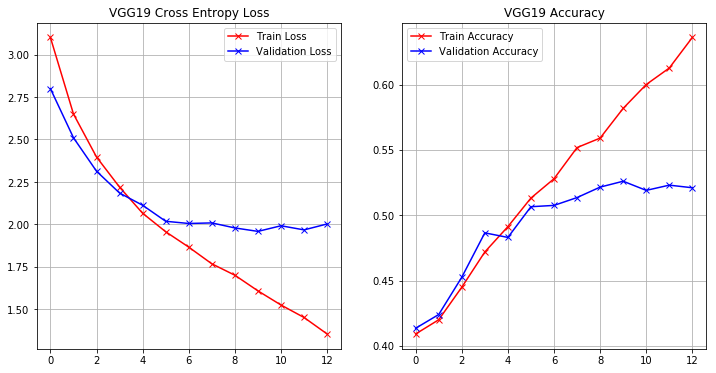

In [56]:
plot_loss_accuracy(trained_vgg, 'VGG19')

#### Evaluation:

In [57]:
score = model_vgg.evaluate(x_val, y_val, verbose=1)
print('VGG19 V1 Test loss:', score[0])
print('VGG19 V1 Top-1 Accuracy:', score[1])
print('VGG19 V1 Top-5 Accuracy:', score[2])

5000/5000 [==============================] - 45s 9ms/step
('VGG19 V1 Test loss:', 9.991571139526368)
('VGG19 V1 Top-1 Accuracy:', 0.365)
('VGG19 V1 Top-5 Accuracy:', 0.9256)


### Conclusions

The Xception V1 and VGG19 models both achieved similar evaulation results but there are some notable differences. The Xception model actually had worse results, but the model did not converge, meaning the optimizer we used was a bit too slow so additional tuning is required to speed up the learning process. Despite this, Xception achieved 30% Top-1 accuracy and 87% Top-5 accuracy with a test loss of around 11. This is respectable since the training set consists of only around 8,000 images, and there are 91 classes to identitfy and predict on. With only 8,000 classes images, not all the categories may even be exposed to the model. If Xception was able to converge, it should in theory out perform VGG19. Notable training time difference however, time per step was longer by almost 200ms, and the overall time per epoch was a minute slower. This is due to the underlying architecture of Xception, as it uses depthwise sepereable convolutions which require more computation as they 'decouple spatial and cross-channel correlations entirely' [*François Chollet*]. Additionally, there pointwise convolutions involved (1x1 kernels) which can be computationally taxing if the input dimension is still large. 

The VGG19 model achieved 36% Top-1 accuracy, 93% Top-5 accuracy and had a test loss around 10 with early stopping occuring at 12 epoch. The model trained very quickly, so the learning rate was sufficient to ensure convergence, but perhaps the learning process was too quick? We could retune the hyperparameters or choose another optimizer to see if a slower learning rate would help any gains in accuracy. Despite the 19 weight-based training blocks, VGG19 was faster to train over each step and epoch. 

The results are not entired conclusive, as we would need to see Xception converge to make note of a true test accuracy and loss, but the two models performed well on the data set, with VGG19 showing better results with faster learning using the same optimizer.

*Please refer to our related paper for more in-depth comaprison and methodology.*